<img src="https://www.luxonis.com/logo.svg" width="400">

# Training a Pose Estimation Model

## 🌟 Overview
In this tutorial, we'll go through the process of training a custom pose estimation model. We'll first create a dataset, set up the training configuration, and then use it to train our own NN model. We'll also validate the performance of our model, export it, and make it ready for deployment on a Luxonis device.

## 📜 Table of Contents
- [🛠️ Installation](#️installation)
- [🗃️ Data Preparation](#data-preparation)
    - [💾 LuxonisDataset](#luxonisdataset)
- [🏋️‍♂️ Training](#️️training)
    - [⚙️ Configuration](#️configuration)
    - [🦾 Train](#train)
- [✍ Test](#test)
    - [🧠 Infer](#infer)
- [🗂️ Export and Archive](#export-and-archive)
- [🤖 Deploy](#deploy)
- [📷 DepthAI Script](#depthai-script)

<a name="️installation"></a>

## 🛠️ Installation


The main focus of this tutorial is using [`LuxonisTrain`](https://github.com/luxonis/luxonis-train), a user-friendly tool designed to streamline the training of deep learning models, especially for edge devices. We'll also use [`LuxonisML`](https://github.com/luxonis/luxonis-ml) since it provides us with a collection of utility functionality and an easy way of creating and managing computer vision datasets called `LuxonisDataset`.

In [ ]:
%pip install -q opencv-python gdown luxonis-train==0.3.4 luxonis-ml==0.6.5 -U

<a name ="data-preparation"></a>

## 🗃️ Data Preparation

First, we need to download and prepare our dataset. This tutorial will use a subset of [`Tiger Pose dataset`](https://github.com/ultralytics/assets/releases/download/v0.0.0/tiger-pose.zip). Our task is to train a model that detect keypoints. 

To download the dataset, we'll run this:

In [2]:
import glob
import json
import os
import zipfile
import gdown

os.makedirs("data", exist_ok=True)

url = "https://github.com/ultralytics/assets/releases/download/v0.0.0/tiger-pose.zip"
output_zip = "./data/tiger-pose.zip"
output_folder = "./data/"

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

if not os.path.exists(output_zip):
    gdown.download(url, output_zip, quiet=False)

with zipfile.ZipFile(output_zip, "r") as zip_ref:
    zip_ref.extractall(output_folder)

# Remove duplicated image
!rm data/train/images/Frame_0.jpg

<a name ="luxonisdataset"></a>

### 💾 LuxonisDataset

Now, let's create a `LuxonisDataset`. First, we need to create a dataset instance, which we'll call `tiger_pose_dataset`.

In [ ]:
from luxonis_ml.data import LuxonisDataset

dataset = LuxonisDataset(dataset_name="tiger_pose_dataset", delete_existing=True) # if dataset with this name already exists then we delete the old instance

To add data to `LuxonisDataset`, you need to create a generator function that yields annotations in the correct format. We need the path to the image, label, bounding boxes and keypoints.

First, Let's create a function called `process_dir`, which will get a path to the directory and return a generator function of type DatasetIterator and a list of paths of added images.

In [ ]:
import os
import glob
import cv2
import numpy as np
from tqdm import tqdm
from luxonis_ml.data import DatasetIterator

def process_dataset(folder: str) -> tuple[DatasetIterator, list[str]]:
    """
    Process a COCO-style pose estimation dataset with text labels.
    
    Args:
        folder: Path to the dataset folder (e.g. tiger_pose/train/)
        
    Returns:
        A tuple containing:
        - A generator that yields annotations in the LuxonisDataset format
        - A list of image paths
    """
    # Find all images in the images folder
    images_dir = os.path.join(folder, "images")
    labels_dir = os.path.join(folder, "labels")
    
    # Get all image paths and sort them
    img_paths = glob.glob(os.path.join(images_dir, "*.jpg"))
    # img_paths.extend(glob.glob(os.path.join(images_dir, "*.png")))
    img_paths = sorted(img_paths)
    
    def generator() -> DatasetIterator:
        for img_path in tqdm(img_paths, desc="Processing dataset"):
            # Get the base filename without extension
            base_name = os.path.splitext(os.path.basename(img_path))[0]
            label_path = os.path.join(labels_dir, f"{base_name}.txt")
            
            # Load the image to get dimensions
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image {img_path}")
                continue
            
            # First yield just the file
            yield {"file": img_path}
            
            # Process each object in the label file
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for i, line in enumerate(f):
                        parts = line.strip().split()
                            
                        # Parse data
                        class_id = int(parts[0])
                        x_center, y_center = float(parts[1]), float(parts[2])
                        box_width, box_height = float(parts[3]), float(parts[4])
                        
                        # Create annotation record
                        record = {
                            "file": img_path,
                            "annotation": {
                                "class": "tiger",
                                "boundingbox": {
                                    "x": x_center - box_width/2,  # Convert center to top-left x
                                    "y": y_center - box_height/2,  # Convert center to top-left y
                                    "w": box_width,
                                    "h": box_height,
                                }
                            }
                        }
                        
                        # Process keypoints if present (format is x1,y1,x2,y2,...)
                        if len(parts) > 5:
                            keypoints_data = parts[5:]
                            if len(keypoints_data) % 2 == 0:  # Make sure we have pairs of coordinates
                                keypoints = []
                                for j in range(0, len(keypoints_data), 2):
                                    x = float(keypoints_data[j])
                                    y = float(keypoints_data[j+1])
                                    # Add keypoint with visibility 2 (visible)
                                    keypoints.append((x, y, 2))
                                
                                record["annotation"]["keypoints"] = {"keypoints": keypoints}
                        
                        yield record
    
    return generator(), img_paths

We will add the generator to our `LuxonisDataset` instance. 

In [ ]:
# dataset.add(COCO_people_subset_generator())
train_gen, train_images = process_dataset(folder="data/train/")
val_gen, val_images = process_dataset(folder="data/val/")

# Add data to the dataset
dataset = dataset.add(train_gen)
dataset = dataset.add(val_gen)

Now, let's split the dataset.

In [10]:
import random
from random import shuffle
random.seed(123)

shuffle(train_images) # shuffle the images
split_idx = int(len(train_images) * 0.8)
actual_train_images = train_images[:split_idx]
actual_val_images = train_images[split_idx:]

dataset.make_splits(
    splits={
        "train": actual_train_images,
        "val": actual_val_images,
        "test": val_images
    }
)

We can check the dataset's information and visualizations of the annotations to verify that the data is correctly loaded and split into subsets.

In [ ]:
!luxonis_ml data info tiger_pose_dataset

WARNING  /opt/conda/lib/python3.11/site-packages/albumentations/__ ]8;id=305148;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=897215;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#92\92]8;;\
         init__.py:24: UserWarning: A new version of                            
         Albumentations is available: 2.0.5 (you have 1.4.20).                  
         Upgrade using: pip install -U albumentations. To disable               
         automatic update checks, set the environment variable                  
         NO_ALBUMENTATIONS_UPDATE to 1.                                         
           check_for_updates()                                                  
                                                                                
╭─────────────── Dataset Info ───────────────╮
│ Name: tiger_pose_dataset                   │
│ Version: 2.0.0                             │
│             

In [ ]:
!luxonis_ml data inspect tiger_pose_dataset # NOTE: If you are on Google Colab this command will not work

<a name ="️️training"></a>

## 🏋️‍♂️ Training

<a name ="️configuration"></a>

### ⚙️ Configuration

We have prepared the dataset and are almost ready for the actual training. The last step is just to set up our training configuration file. The whole training process in `LuxonisTrain` doesn't require any coding. We advise you to take one of the base configuration files from [here](https://github.com/luxonis/luxonis-train/tree/main/configs) depending on the task, and then edit it to fit your needs.

In our case, since we are training a pose estimation model, we'll take a [`keypoint_bbox_light_model.yaml`](https://github.com/luxonis/luxonis-train/blob/main/configs/keypoint_bbox_light_model.yaml) config as a starting point, which downloads pre-trained COCO weights, making it ideal for fine-tuning. There are many parameters that we can change, and we advise you to go through the [`documentation`](https://github.com/luxonis/luxonis-train/blob/main/configs/README.md) to find all of them. In this tutorial, we'll only go through some basic ones to get you started on your journey.

#### Model
In this section, you can either choose one of the predefined architectures (all of them listed [here](https://github.com/luxonis/luxonis-train/tree/main/luxonis_train/config/predefined_models)) or create a completely custom neural network by connecting different nodes, losses, metrics, and visualizers. We'll go with the predefined `KeypointDetectionModel`.

#### Loader
This section of the config refers to the data loading. You can either set up your custom `Loader` or use the default one with the `LuxonisDataset`. In our case, we'll go with the second option; all we need to do is set `dataset_name` to `tiger_pose_dataset`.

#### Trainer
In this section, we can set up everything connected to the actual training. You can change preprocessing, batch size, epochs, add callbacks, augmentations, change optimizers, schedulers, and more. Please refer to the [complete documentation](https://github.com/luxonis/luxonis-train/tree/main/configs). 

#### Augmentations
In this tutorial, we'll leave most things as they are; the only change will be adding some augmentations. `Luxonis-train` uses [`Albumentations`](https://albumentations.ai/) for augmentations by adding custom ones like `Mosaic4` and `MixUp`. You can use [this demo](https://demo.albumentations.ai/) to experiment and find those that work for your specific training run.

#### Callbacks 
Callbacks are very helpful when merging more functionalities into a single training run. For example, we want to train the model, evaluate it on a test subset, export it, and create an archive. These steps can be defined through the config and done by a single call. You can check out all the available callbacks [here](https://github.com/luxonis/luxonis-train/tree/main/luxonis_train/callbacks).

Below is a starting point for our config. As mentioned before, we already made some changes to it, so it works with this tutorial (model name and dataset name change), but feel free to edit it further and make it your own. When you are done editing, you can execute the cell, and the file will be written and ready to use.

**Note**: In case you don't have enough computing power on your machine, you can either use [Google Colab](https://colab.research.google.com/) (with GPU enabled), or you can try tweaking the training hyperparameters (such as lowering number of epochs or batch size). However, please be aware that bad parametrization can result in worse performance.

In [14]:
%%writefile tiger_keypoint_detection_model_config.yaml
model:
  name: tiger_keypoint_detection_light
  predefined_model:
    name: KeypointDetectionModel
    params:
      variant: light
      loss_params:
        iou_type: "ciou"
        # Should be 7.5 * accumulate_grad_batches for the best results
        iou_loss_weight: 60
        # Should be 0.5 * accumulate_grad_batches for the best results
        class_loss_weight: 4
        # Should be 12 * accumulate_grad_batches for the best results
        regr_kpts_loss_weight: 96
        # Should be 1 * accumulate_grad_batches for the best results
        vis_kpts_loss_weight: 8

loader:
  params:
    dataset_name: tiger_pose_dataset


trainer:
  precision: "16-mixed"
  preprocessing:
    train_image_size: [384, 512]
    keep_aspect_ratio: true
    normalize:
      active: true
      params:
        mean: [0., 0., 0.]
        std: [1, 1, 1]

  batch_size: 8
  epochs: 300
  n_workers: 4
  validation_interval: 10
  n_log_images: 8
  gradient_clip_val: 10

  callbacks:
    - name: EMACallback
      params:
        decay: 0.9999
        use_dynamic_decay: True
        decay_tau: 2000
    # For best results, always accumulate gradients to
    # effectively use 64 batch size
    - name: GradientAccumulationScheduler
      params:
        # warmup phase is 3 epochs
        scheduling:
          0: 1
          1: 4
          2: 8

  training_strategy:
    name: "TripleLRSGDStrategy"
    params:
      warmup_epochs: 3
      warmup_bias_lr: 0.0
      warmup_momentum: 0.8
      lr: 0.01
      lre: 0.00001
      momentum: 0.937
      weight_decay: 0.0005
      nesterov: True
      cosine_annealing: False

Overwriting tiger_keypoint_detection_model_config.yaml


<a name ="train"></a>

### 🦾 Train

To start the training, we need to initialize the `LuxonisModel`, pass it the path to the configuration file, and call the `train()` method on it.

**Note**: LuxonisTrain also supports all these commands through usage of its CLI ([docs here](https://github.com/luxonis/luxonis-train/tree/main?tab=readme-ov-file#-cli)), no code required. We won't use them for tutorial purposes, but feel free to use them when you do it yourself.

In [ ]:
from luxonis_train import LuxonisModel

config_path = "tiger_keypoint_detection_model_config.yaml"

luxonis_model = LuxonisModel(config_path)
luxonis_model.train()

`LuxonisTrain` has also already implemented automatic tracking of training runs. By default, `Tensorboard` is used, and to look at the losses, metrics, and visualizations during training, we can inspect the logs. If you check the `output` folder, you'll see that every run creates a new directory, and each run also has its training logs in the `./output/tensorboard_logs` where the name of the folder matches the run's name. To make all the subsequent commands work automatically, please set the name of your run below.

In [12]:
RUN_NAME = "<YOUR_RUN_NAME>"

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output/tensorboard_logs/{RUN_NAME}/ # TODO: Change the name of the training run

<a name ="test"></a>

## ✍ Test

Now, we have a trained model that performs well on the validation set. The next step is to check its performance on the testing set, a collection of images we've kept hidden from the model. It should only be used to evaluate whether the model is good objectively. Since this is a pose estimation task, we use the Object Keypoint Similarity, Mean Average Precision, Mean Average Recall, and F1 Score metrics to check the model performance quantitatively.

If you check out the run directory, you'll see two folders inside: `best_val_metric` and `min_val_loss`. Both have checkpoint files generated during training based on best validation metric performance and minimal validation loss. For evaluation, we'll want to use one of these checkpoints; we recommend that you use one that has the lowest validation loss.

In [17]:
weights = luxonis_model.get_min_loss_checkpoint_path() # gets checkpoint where validation loss was the lowest
# weights = luxonis_model.get_best_metric_checkpoint_path() # gets checkpoint where validation metric was the highest

metrics = luxonis_model.test(view="test", weights=weights)

INFO     The following callbacks returned in `LightningModule.configure_callbacks` will override    ]8;id=839526;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=161435;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#64\64]8;;\
         existing callbacks passed to Trainer: EMACallback, GradientAccumulationScheduler,                         
         ModelCheckpoint, RichModelSummary, TrainingManager                                                        

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Corrupt JPEG data: premature end of data segment


Output()

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of d

INFO     Test loss: 117.1896                                                               ]8;id=233178;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=941111;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/lightning/luxonis_lightning.py#667\667]8;;\

────────────────────────────────────────────────────── Test ───────────────────────────────────────────────────────

Loss: 117.18960189819336

Metrics:

       EfficientKeypointBBoxHead       
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓
┃ Name                     ┃ Value    ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩
│ ObjectKeypointSimilarity │ 0.87396  │
│ MeanAveragePrecision     │ 0.78874  │
│ kpt_map_50               │ 1.00000  │
│ kpt_map_75               │ 0.97441  │
│ kpt_map_medium           │ -1.00000 │
│ kpt_map_large            │ 0.78874  │
│ kpt_mar                  │ 0.80377  │
│ kpt_mar_50               │ 1.00000  │
│ kpt_mar_75               │ 0.98113  │
│ kpt_mar_medium           │ -1.00000 │
│ kpt_mar_large            │ 0.80377  │
│ kpt_f1_50                │ 1.00000  │
│ kpt_f1_75                │ 0.97776  │
│ kpt_f1_medium            │ -1.00000 │
│ kpt_f1_large             │ 0.79618  │
│ mcc                      │ 0.00000  │
└──────────────────────────┴──────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Test main metric (EfficientKeypointBBoxHead/MeanAveragePrecision): 0.7887         ]8;id=199040;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=420184;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/lightning/luxonis_lightning.py#677\677]8;;\

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Test metric                       ┃                      DataLoader 0                      ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                       test/loss                        │                   117.18960571289062                   │
│ test/loss/EfficientKeypointBBoxHead/EfficientKeypoint… │                   117.18960571289062                   │
│ test/loss/EfficientKeypointBBoxHead/EfficientKeypoint… │                   0.5252976417541504                   │
│ test/loss/EfficientKeypointBBoxHead/EfficientKeypoint… │                  0.016245989128947258                  │
│ test/loss/EfficientKeypointBBoxHead/EfficientKeypoint… │                  0.13038374483585358                   │
│ test/loss/EfficientKeypointBBoxHead/EfficientKeypoint… │                  0.024381563067436218                  │
│ test/metric/EfficientKeypointBBoxHead/MeanAveragePrec… │                   0.7887365221977234                   │
│ test/metric/EfficientKeypointBBoxHead/ObjectKeypointS… │                   0.873960018157959                    │
│    test/metric/EfficientKeypointBBoxHead/kpt_f1_50     │                          1.0                           │
│    test/metric/EfficientKeypointBBoxHead/kpt_f1_75     │                   0.9777579307556152                   │
│   test/metric/EfficientKeypointBBoxHead/kpt_f1_large   │                   0.7961840033531189                   │
│  test/metric/EfficientKeypointBBoxHead/kpt_f1_medium   │                          -1.0                          │
│    test/metric/EfficientKeypointBBoxHead/kpt_map_50    │                          1.0                           │
│    test/metric/EfficientKeypointBBoxHead/kpt_map_75    │                   0.974406898021698                    │
│  test/metric/EfficientKeypointBBoxHead/kpt_map_large   │                   0.7887365221977234                   │
│  test/metric/EfficientKeypointBBoxHead/kpt_map_medium  │                          -1.0                          │
│     test/metric/EfficientKeypointBBoxHead/kpt_mar      │                   0.8037735819816589                   │
│    test/metric/EfficientKeypointBBoxHead/kpt_mar_50    │                          1.0                           │
│    test/metric/EfficientKeypointBBoxHead/kpt_mar_75    │                   0.9811320900917053                   │
│  test/metric/EfficientKeypointBBoxHead/kpt_mar_large   │                   0.8037735819816589                   │
│  test/metric/EfficientKeypointBBoxHead/kpt_mar_medium  │                          -1.0                          │
│       test/metric/EfficientKeypointBBoxHead/mcc        │                          0.0                           │
└────────────────────────────────────────────────────────┴────────────────────────────────────────────────────────┘

<a name ="infer"></a>

### 🧠 Infer

Usually, we also want to visualize the prediction of the trained model on test images to ensure it does what it is supposed to do. This is called inference, and we can perform it either on one of the views (e.g., test) or a random image, directory of images, or whole video (for more details, refer to the [docs](https://github.com/luxonis/luxonis-train/tree/main?tab=readme-ov-file#inference)). In our case, we'll infer the model on test images.

In [ ]:
# NOTE: If you are using Google Colab use this and images will be saved to "infer_results_people_model" directory
luxonis_model.infer(weights=weights, save_dir="infer_results_tiger_pose_model", view="test")

# NOTE: If you are not using Google Colab use this and images will be displayed
# luxonis_model.infer(
#     weights=weights,
#     view="test"
# ) 

Now, let's visualize one of the predictions.

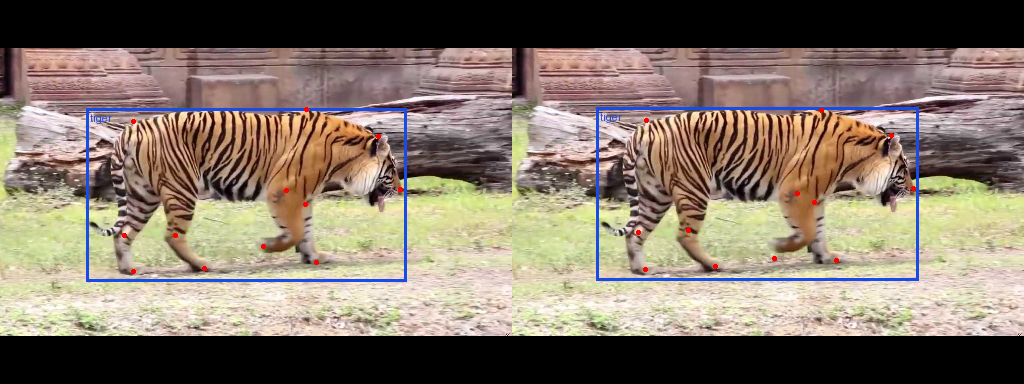

In [19]:
from IPython.display import Image
Image(filename='infer_results_tiger_pose_model/EfficientKeypointBBoxHead_KeypointVisualizer_2.png')

<a name ="export-and-archive"></a>

## 🗂️ Export and Archive

Once the model is trained and tested, we want to prepare it for deployment on the device. This preparation consists of 2 steps. First, we want to export the model trained with PyTorch to a more general format called [`Open Neural Network Exchange (ONNX)`](https://onnx.ai/). Then, we want to package this exported model with all the metadata containing information about the inputs, outputs, and training configuration used. This is called archiving. These steps can be done quickly with just one command in `LuxonisTrain`.

In [20]:
archieve_path = luxonis_model.archive(weights=weights)
print("Model archieved to:", archieve_path)

WARNING  No model executable specified for archiving.                                                   ]8;id=871297;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=904302;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#747\747]8;;\

INFO     Exporting model to ONNX...                                                                     ]8;id=560918;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=970790;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#749\749]8;;\

INFO     Reparametrizing 'EfficientRep'.                                                        ]8;id=163772;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/nodes/backbones/efficientrep/efficientrep.py\efficientrep.py]8;;\:]8;id=896858;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/nodes/backbones/efficientrep/efficientrep.py#162\162]8;;\

INFO     Reparametrizing 'RepPANNeck'.                                                           ]8;id=431785;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/nodes/necks/reppan_neck/reppan_neck.py\reppan_neck.py]8;;\:]8;id=835895;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/nodes/necks/reppan_neck/reppan_neck.py#242\242]8;;\

WARNING  /opt/conda/lib/python3.11/site-packages/luxonis_train/utils/boundingbox.py:360:              ]8;id=403006;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=349971;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#92\92]8;;\
         TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a                   
         tensor of different shape won't change the number of iterations executed (and might lead to               
         errors or silently give incorrect results).                                                               
           for feature, stride in zip(features, strides, strict=False):                                            
                                                                                                                   

WARNING  /opt/conda/lib/python3.11/site-packages/luxonis_train/utils/boundingbox.py:392:              ]8;id=424363;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=449456;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#92\92]8;;\
         TracerWarning: Using len to get tensor shape might cause the trace to be incorrect.                       
         Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead                
         to errors or silently give incorrect results.                                                             
           curr_n_anchors = len(anchor)                                                                            
                                                                                                                   

WARNING  /opt/conda/lib/python3.11/site-packages/luxonis_train/utils/boundingbox.py:395:              ]8;id=45618;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=226484;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#92\92]8;;\
         TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect.              
         We can't record the data flow of Python values, so this value will be treated as a constant               
         in the future. This means that the trace might not generalize to other inputs!                            
           torch.full((curr_n_anchors, 1), stride.item(), dtype=feature.dtype)                                     
                                                                                                                   

INFO     Model exported to output/8-pink-prawn/export/tiger_keypoint_detection_light.onnx  ]8;id=820046;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/lightning/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=740216;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/lightning/luxonis_lightning.py#408\408]8;;\

INFO     Simplifying ONNX model...                                                               ]8;id=740075;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/utils/export_utils.py\export_utils.py]8;;\:]8;id=275978;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/utils/export_utils.py#53\53]8;;\

INFO     ONNX model saved to output/8-pink-prawn/export/tiger_keypoint_detection_light.onnx      ]8;id=554843;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/utils/export_utils.py\export_utils.py]8;;\:]8;id=886221;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/utils/export_utils.py#62\62]8;;\

INFO     `exporter.reverse_input_channels` not specified. Using the `trainer.preprocessing.color_space` ]8;id=969973;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=2489;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#381\381]8;;\
         value to determine if the channels should be reversed. `color_space` = 'RGB' ->                           
         `reverse_input_channels` = `True`                                                                         

INFO     NN Archive saved to output/8-pink-prawn/archive/tiger_keypoint_detection_light.onnx.tar.xz     ]8;id=544991;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=795755;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#815\815]8;;\

Model archieved to: output/8-pink-prawn/archive/tiger_keypoint_detection_light.onnx.tar.xz


Notice that two new folders were created in our run directory. One is called `export` and has an ONNX model while the other is called `archive` which has `.tar.xz` file. The tar file is a compressed file that holds the aforementioned ONNX model with all the model metadata.

<a name ="deploy"></a>

## 🤖 Deploy

Now that we have successfully exported and archived the model, we aim to deploy it to the Luxonis device. The model's specific format depends on the Luxonis device series you have. We will show you how to use our [`ModelConverter`](https://github.com/luxonis/modelconverter) to convert the model as simply as possible. 

We'll start by installing the `ModelConverter`.

In [ ]:
%pip install -q modelconv@git+https://github.com/luxonis/modelconverter.git@main -U

We will use `ModelConverter`'s Python API, which utilizes our [`HubAI`](https://hub.luxonis.com) to convert the model in the background. To start with the conversion, you need to create an account on the `HubAI` platform and obtain the API key for your team.

To log in to HubAI, use the following command:

In [ ]:
!modelconverter hub login

To convert the model, we can use either CLI or Python API. We'll use the latter. For more information, please look [here](https://github.com/luxonis/modelconverter?tab=readme-ov-file#online-usage).

The call below will create a new model card inside your team on `HubAI` with the model file and details uploaded. It will further convert the model on the cloud to the selected target platform (e.g. [`RVC2`](https://rvc4.docs.luxonis.com/hardware/platform/rvc/rvc2/), [`RVC4`](https://rvc4.docs.luxonis.com/hardware/platform/rvc/rvc4/)) and download the converted model to your device. Choosing the target is as simple as setting a `target` argument in the `convert` function.

Besides this, there are some platform-specific parameters. To check them out, please visit our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/conversion/rvc-conversion/offline/modelconverter/#ModelConverter-Parameters-Platform-Specific).

In [3]:
# NN_ARCHIVE_PATH = "<YOUR_MODEL_ARCHIVE_PATH>"
NN_ARCHIVE_PATH = "tiger_keypoint_detection_light.onnx.tar.xz"

In [4]:
from modelconverter import convert


converted_model = convert(
    "rvc2", 
    path=NN_ARCHIVE_PATH,
    name="Tiger Pose Estimation Model",
    description_short="Tiger Pose Estimation Model",
    tasks=["KEYPOINT_DETECTION"],
    license_type="MIT",
    is_public=False
)

Model 'Tiger Pose Estimation Model' created with ID '555acb2e-d2a4-4266-a69e-b55af1424a2f'

Model variant 'Tiger Pose Estimation Model 384x512' created with ID '1c9b957d-a057-4b26-9ad0-d1c5065df2ae'

Model instance 'Tiger Pose Estimation Model 384x512 base instance' created with ID 
'0e214d39-143a-4d14-a33a-53f6ee2cb8c7'

File 'tiger_keypoint_detection_light.onnx.tar.xz' uploaded to model instance '0e214d39-143a-4d14-a33a-53f6ee2cb8c7'

Model instance 'Tiger Pose Estimation Model 384x512 exported to rvc2' created for rvc2 export with ID 
'0eb197f4-5635-4805-a00f-89bf77aab8ce'

Output()

Donwloaded 'tiger-pose-estimation-model-384x512-exported-to-rvc2/tiger_keypoint_detection_light.rvc2.tar.xz'

We have successfully converted our trained model for an RVC2 device, so let's test it! Please copy the path to the downloaded archive with the converted model from the output log of the last code cell; we will use it in the next section.

In [1]:
MODEL_PATH = "insert_your_model_path"

To check out other possible ways to convert your model for our devices, please refer to our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/conversion/rvc-conversion/).

<a name ="depthai-script"></a>

## 📷 DepthAI Script

To test our model on one of our cameras, we first need to install [`DepthAI`](https://rvc4.docs.luxonis.com/software/) in version 3 and [`DepthAI Nodes`](https://rvc4.docs.luxonis.com/software/ai-inference/depthai-nodes/). Moreover, the script we'll write must run locally and require a Luxonis device connected to your machine.

In [ ]:
%pip install --extra-index-url https://artifacts.luxonis.com/artifactory/luxonis-python-release-local/ depthai==3.0.0a14
%pip install -q depthai-nodes@git+https://github.com/luxonis/depthai-nodes.git@main -U

Here is the script to run the model on the DepthAI device:

In [ ]:
import cv2
import depthai as dai
import numpy as np
from depthai_nodes import ImgDetectionExtended, ImgDetectionsExtended
from depthai_nodes.node import ParsingNeuralNetwork
from typing import List

labels = ["tiger"]

def draw_extended_image_detections(
    frame: np.ndarray, detections: List[ImgDetectionExtended], labels=None
):
    """Draws (rotated) bounding boxes on the given frame."""

    for detection in detections:
        rect = detection.rotated_rect
        points = rect.getPoints()

        bbox = np.array([[point.x, point.y] for point in points])
        if np.any(bbox < 1):
            bbox[:, 0] = bbox[:, 0] * frame.shape[1]
            bbox[:, 1] = bbox[:, 1] * frame.shape[0]
        bbox = bbox.astype(int)
        cv2.polylines(frame, [bbox], isClosed=True, color=(255, 0, 0), thickness=2)

        try:
            keypoints = detection.keypoints
            for kp in keypoints:
                cv2.circle(
                    frame,
                    (int(kp.x * frame.shape[1]), int(kp.y * frame.shape[0])),
                    5,
                    (0, 0, 255),
                    -1,
                )
        except Exception:
            pass

        outer_points = rect.getOuterRect()
        xmin = int(outer_points[0] * frame.shape[1])
        ymin = int(outer_points[1] * frame.shape[0])
        cv2.putText(
            frame,
            f"{detection.confidence * 100:.2f}%",
            (xmin + 10, ymin + 20),
            cv2.FONT_HERSHEY_TRIPLEX,
            0.5,
            (255, 0, 0),
        )
        if labels is not None:
            cv2.putText(
                frame,
                labels[detection.label],
                (xmin + 10, ymin + 40),
                cv2.FONT_HERSHEY_TRIPLEX,
                0.5,
                (255, 0, 0),
            )

    return frame


def visualize_extended(
    frame: np.ndarray, message: ImgDetectionsExtended, extraParams: dict
):
    """Visualizes the pose detections on the frame."""

    detections = message.detections
    classes = extraParams.get("classes", None)

    if classes is None:
        raise ValueError("Classes are required for visualization.")

    frame = draw_extended_image_detections(frame, detections, classes)

    cv2.imshow("Pose Estimation", frame)
    if cv2.waitKey(1) == ord("q"):
        cv2.destroyAllWindows()
        return True

    return False


device = dai.Device()
platform = device.getPlatform()

nn_archive = dai.NNArchive(MODEL_PATH)
img_frame_type = dai.ImgFrame.Type.BGR888i if platform.name == "RVC4" else dai.ImgFrame.Type.BGR888p

with dai.Pipeline(device) as pipeline:
    cam = pipeline.create(dai.node.Camera).build()
    nn_with_parser = pipeline.create(ParsingNeuralNetwork).build(
        cam.requestOutput((512, 384), type=img_frame_type), 
        nn_archive
    )
    parser_output_queue = nn_with_parser.out.createOutputQueue()
    frame_queue = nn_with_parser.passthrough.createOutputQueue()

    pipeline.start()

    while pipeline.isRunning():
        frame: np.ndarray = frame_queue.get().getCvFrame()
        nn_output: dai.ImgDetections = parser_output_queue.get()

        if visualize_extended(frame, nn_output, extraParams={"classes": labels}):
            pipeline.stop()
            break

Yay! 🎉🎉🎉 Huge congratulations, you have successfully finished this tutorial in which you deployed a pose estimation model trained using `luxonis-train` on a dataset to our camera!